In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# V52 lidar study

In [2]:
tstart,tend = 40, 50
xstart,xend = 22.63, 23.98

In [3]:
vlos_data = '/Users/equon/WakeDynamics/V52_lidar_wake/vlos_digitized.csv'

## read digitized data 
- image from https://www.vindenergi.dtu.dk/english/news/2018/12/new-generation-of-wind-scanners-developed-by-dtu?id=21486c47-1a16-45da-b7f2-afad61e867e7
- digitized using https://apps.automeris.io/wpd/

In [4]:
df = pd.read_csv(vlos_data,header=None,names=['t','vlos'])

In [5]:
# distance from lidar [m]
df['x'] = (df['t']-tstart)/(tend-tstart) * (xend-xstart) + xstart

(-8, 8)

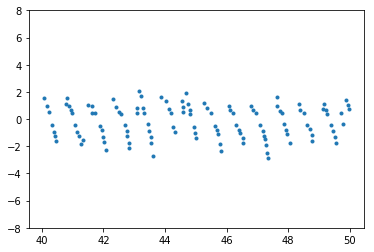

In [6]:
plt.plot(df['t'],df['vlos'],'.')
plt.ylim((-8,8))

## estimate passage frequency

In [7]:
dt = 0.1
t = np.arange(40+dt,50,dt)
Nt = len(t)

In [8]:
vlos = np.interp(t, df['t'], df['vlos'])

In [9]:
f = np.fft.fftfreq(Nt,d=dt)
S = np.fft.fft(vlos)

In [10]:
PSD = np.abs(S[:Nt//2])**2
imax = np.argmax(PSD)
fmax = f[imax]
print(fmax)

1.3131313131313131


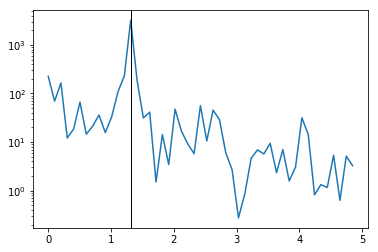

In [11]:
fig,ax = plt.subplots()
ax.semilogy(f[:Nt//2], PSD)
ax.axvline(fmax, color='k', lw=1)

In [12]:
T = 1/fmax
rotor_period = 3*T # 3 blades
rotor_rpm = 1/rotor_period * 60 # should be between 14 - 31.4 rpm
print('time between vortex passage:',T)
print(rotor_rpm,'rpm')

time between vortex passage: 0.7615384615384615
26.262626262626263 rpm


## split up periods

In [13]:
tlimits = np.arange(tstart,tend+T,T)

In [14]:
tlimits

array([40.        , 40.76153846, 41.52307692, 42.28461538, 43.04615385,
       43.80769231, 44.56923077, 45.33076923, 46.09230769, 46.85384615,
       47.61538462, 48.37692308, 49.13846154, 49.9       , 50.66153846])

In [15]:
df['period'] = pd.cut(df['t'], tlimits, labels=range(len(tlimits)-1))

(-3, 3)

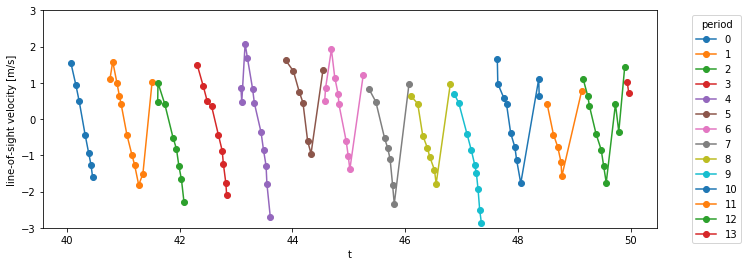

In [16]:
fig,ax = plt.subplots(figsize=(11,4))
df.set_index('t').pivot(columns='period')['vlos'].plot(ax=ax,marker='o')
ax.legend(loc='upper left',bbox_to_anchor=(1.05,1),title='period')
ax.set_ylabel('line-of-sight velocity [m/s]')
ax.set_ylim((-3,3))

## modeled vortex

In [17]:
def vort_soln(r,separation=1.0,strength=1.0,tref=0.0,vbias=0.0,
              tol=0.1,debug=False):
    """The tolerance determines the number of additional vortices to account
    for so that the induced velocity for the farthest vortex is `tol` m/s
    """
    r0 = np.mod(r-tref, separation)
    r0[r0>separation/2] -= separation
    Nvort = strength/(2*np.pi*separation*tol)
    if debug: print('Nvort ~',Nvort)
    Nvort = int(np.ceil(Nvort))
    if debug: print('v_theta(Nvort*sep) =', strength / (2*np.pi*Nvort*separation))
    u = strength / (2*np.pi*r0)
    if debug: plt.plot(r0,u,'o')
    for i in range(1,Nvort+1):
        u += strength / (2*np.pi*(r0-i*separation))
        u += strength / (2*np.pi*(r0+i*separation))
        if debug: plt.plot(r0,u,'o')
    return u + vbias

Text(0.5, 1.0, 'potential flow vortex solution')

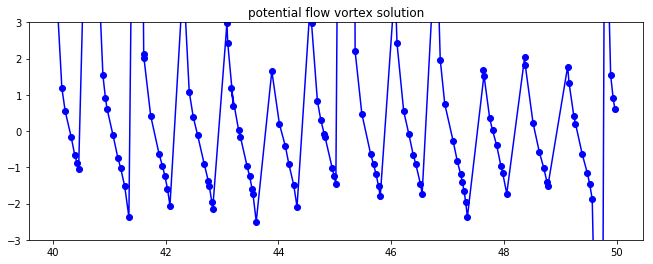

In [18]:
fig,ax = plt.subplots(figsize=(11,4))
plt.plot(df['t'], vort_soln(df['t'], strength=2.0, separation=0.75, tref=tstart, vbias=-0.5), 'b-o')
# tvort = np.arange(tstart,tend+0.75,0.75)
# plt.plot(tvort,np.zeros(len(tvort)),'ko')
plt.ylim((-3,3))
plt.title('potential flow vortex solution')

## optimize vortex parameters

In [19]:
from scipy.optimize import least_squares

In [20]:
# guess = [1.0, T, 0, -0.5]
# bounds = (
#     [0.5, 0.5, -0.5, -1],
#     [2.0, 1.0, 0.5, 0],
# )
# def optfun(x):
#     strength, separation, toffset_frac, vbias = x
#     t0 = toffset_frac*separation + tstart
#     uthe = vort_soln(df['t'], separation=separation, strength=strength, tref=t0, vbias=vbias)
#     return uthe - df['vlos']

In [21]:
def calc_rankine(r,strength,rc):
    utheta = strength / (2*np.pi*r)
    in_core = np.where(np.abs(r) < rc)
    utheta[in_core] = strength*r[in_core]/(2*np.pi*rc**2)
    return utheta

In [22]:
def vort_soln_rankine(r,separation=1.0,strength=1.0,tref=0.0,vbias=0.0,
                      rcfrac=0.1,
                      tol=0.1):
    """The tolerance determines the number of additional vortices to account
    for so that the induced velocity for the farthest vortex is `tol` m/s
    
    For the core radius, there is an implicit conversion from time to length.
    """
    r0 = np.mod(r-tref, separation)
    r0[r0 > separation/2] -= separation
    Nvort = strength/(2*np.pi*separation*tol)
    Nvort = int(np.ceil(Nvort))
    u = calc_rankine(r0, strength, rcfrac*separation)
    for i in range(1,Nvort+1):
        u += calc_rankine(r0-i*separation, strength, rcfrac*separation)
        u += calc_rankine(r0-i*separation, strength, rcfrac*separation)
    return u + vbias

In [23]:
# strength, separation, toffset, vbias, rcfrac
# - these are all ad hoc values except for `separation` which comes from the FFT analysis
guess = [1.0, T, 0, -0.5, 0.2]
bounds = (
    [0.5, 0.5, -0.5, -1, 0.01],
    [10.0, 1.0, 0.5, 0, 0.5],
)
def optfun(x):
    strength, separation, toffset_frac, vbias, rcfrac = x
    t0 = toffset_frac*separation + tstart
    uthe = vort_soln_rankine(df['t'].values, separation=separation, strength=strength, tref=t0, vbias=vbias, rcfrac=rcfrac)
    return uthe - df['vlos']

In [24]:
soln = least_squares(optfun, guess, bounds=bounds, verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1313e+02                                    6.15e+02    
       1              2         5.0575e+01      6.26e+01       3.59e-01       1.57e+02    
       2              3         3.5364e+01      1.52e+01       2.41e-01       3.08e+02    
       3              7         3.4559e+01      8.05e-01       4.43e-03       8.42e+01    
       4              9         3.4401e+01      1.57e-01       2.22e-03       2.91e+01    
       5             11         3.4360e+01      4.12e-02       1.15e-03       2.53e+01    
       6             12         3.4298e+01      6.23e-02       2.37e-03       2.43e+01    
       7             16         3.4296e+01      1.93e-03       7.23e-05       2.43e+01    
       8             20         3.4296e+01      5.98e-05       2.25e-06       2.43e+01    
       9             21         3.4296e+01      1.20e-04       4.51e-06       2.43e+01    

In [25]:
soln['x']

array([ 0.94701675,  0.75361199, -0.03535327, -0.07490391,  0.10559218])

separation 0.9470167458956108
strength 0.7536119853409329
delta_t0/separation -0.035353268621836104
vbias -0.0749039077009582
r_c/separation 0.1055921756688707


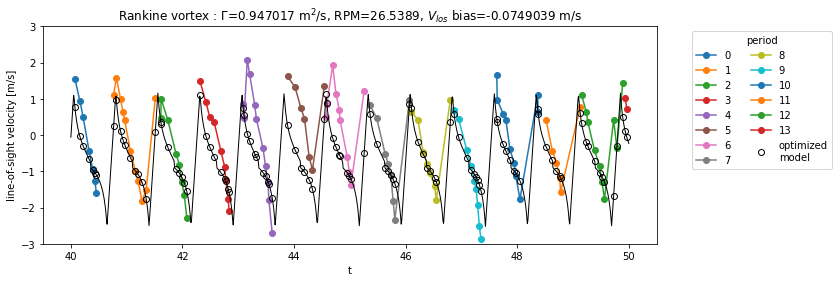

In [26]:
fig,ax = plt.subplots(figsize=(11,4))
df.set_index('t').pivot(columns='period')['vlos'].plot(ax=ax,marker='o')

strength, separation, tfrac, vbias, rcfrac = soln['x']
t0 = tfrac*separation + tstart
ax.plot(df['t'], vort_soln_rankine(df['t'].values, separation=separation, strength=strength, tref=t0, vbias=vbias, rcfrac=rcfrac),
        'ko', markerfacecolor='none', label='optimized\nmodel')
tt = np.linspace(40,50,1001)
ax.plot(tt, vort_soln_rankine(tt, separation=separation, strength=strength, tref=t0, vbias=vbias, rcfrac=rcfrac),
        'k-', lw=1)

ax.legend(loc='upper left',bbox_to_anchor=(1.05,1),
          title='period',ncol=2)
ax.set_ylabel('line-of-sight velocity [m/s]')
ax.set_ylim((-3,3))
ax.set_title(r'Rankine vortex : $\Gamma$={:g} m$^2$/s, RPM={:g}, $V_{{los}}$ bias={:g} m/s'.format(
    strength, 60/(3*separation), vbias
))

for name,val in zip(['separation', 'strength', 'delta_t0/separation', 'vbias', 'r_c/separation'], soln['x']):
    print(name,val)